In [0]:
!pip  install --upgrade networkx==2.7.1

     |████████████████████████████████| 2.0 MB 6.0 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.1
    Uninstalling networkx-2.8.1:
      Successfully uninstalled networkx-2.8.1
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


# Arbitrage

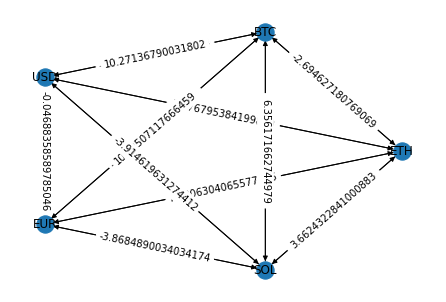

Out[2]: 6.952399799953213e-05

In [0]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
def get_arbitrage(json_, graph = False):
    """
    Usamos la función find negative cycle del
    paquete para gráficas networkx para hallar ciclos negativos en
    una gráfica dirigida que representa los datos de tipos de cambio.
    """
    # Build digraph
    D = nx.DiGraph()
    done = set()
    for k,v in json_.items():
        for s in v:
            if s!=k and (k,s) not in done:                
                q = -np.log(json_[k][s]) + 0.000000000001
                D.add_edge(k,s,weight = q)
                done.add((k,s))
    if graph:
        pos = nx.circular_layout(D)
        nx.draw(D,pos,with_labels= True) 
        labels = nx.get_edge_attributes(D,'weight')
        nx.draw_networkx_edge_labels(D,pos,edge_labels=labels)
        plt.show()

    nc = nx.algorithms.find_negative_cycle(D,'BTC')
    s = 0
    for i,u in enumerate(nc[:-1]):
        s += D[u][nc[i+1]]['weight']
    return float(np.exp(-s)-1)

example = {'ETH': {'ETH': 1,
  'BTC': 0.06756,
  'USD': 1952.21,
  'EUR': 1864.41,
  'SOL': 38.95},
 'BTC': {'ETH': 14.8,
  'BTC': 1,
  'USD': 28890.48,
  'EUR': 27586.85,
  'SOL': 576.04},
 'USD': {'ETH': 0.0005122,
  'BTC': 3.461e-05,
  'USD': 1,
  'EUR': 0.9542,
  'SOL': 0.01995},
 'EUR': {'ETH': 0.0005364,
  'BTC': 3.625e-05,
  'USD': 1.048,
  'EUR': 1,
  'SOL': 0.02089},
 'SOL': {'ETH': 0.02567,
  'BTC': 0.001736,
  'USD': 50.13,
  'EUR': 47.87,
  'SOL': 1}}
get_arbitrage(example,True)

In [0]:
criptos_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "criptos2") \
    .load()

criptos_df_s = criptos_df.selectExpr("value",'timestamp')

In [0]:
from pyspark.sql.functions import explode,split,col,from_json

criptos_prices = criptos_df_s.select(col("value"),col('timestamp'))
print(criptos_prices)

DataFrame[value: binary, timestamp: timestamp]


## Oportunidades de Arbitrage

In [0]:
import json
from pyspark.sql.functions import udf  # user define function (udf)
from pyspark.sql.types import FloatType

k_arbitrage = udf(lambda x: get_arbitrage(eval(x)), FloatType())
cripto_tab = criptos_prices.withColumn('arbi', k_arbitrage( criptos_prices.value.cast('string')))
print(type(cripto_tab))

<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
writeBitcoin = cripto_tab.writeStream.format("memory"). \
    queryName("query"). \
    trigger(processingTime='1 seconds'). \
    start()

In [0]:
%sql
select arbi as arbitrage_gain,DATE_FORMAT(timestamp,'hh:mm:ss') as hour
from query

arbitrage_gain,hour
7.3042E-5,03:54:03
1.3699998E-5,03:54:05
7.3042E-5,03:54:07
6.13E-5,03:54:09
6.13E-5,03:54:10
7.465098E-6,03:54:12
4.50509E-5,03:54:14
1.2476E-4,03:54:16
2.1679999E-4,03:54:17


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e588c84d-c012-4c07-8593-b08d1bf1b087' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>